# SeSiMe
### Sentence/Sequence Similarity Measure

### Goal:  Compare/benchmark different similarity measures for MS-MS spectra
Import MS data and create documents.

Testing here: Model trained on very large MS/MS spectral dataset ("all of gnps").
### here: GNPS Dataset of about 500,000 spectra.

## Outline:
1. Importing, creating documents
2. Plotting functions
3. For benchmarking: molecular similarity
4. Spec2Vec  
4.1. Spec2Vec trained on unique smiles dataset  
4.2. Spec2Vec trained on all-GNPS dataset

## 1. Importing, creating documents

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data from gnps/unique smiles dataset
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


### Note
In total it would be about 100.000 peak-words plus about 50.000 loss-words. Many occur only once in the entire corpus and are hence filtered out (makes not sense to place them somewhere in word-space, would be arbitrary!).

Few also are filtered out because they occur too often (in more than 20% of the spectra). Those words have little discriminative power and are hence ignored. Might still be worth keeping them in for comparison!

***
## 2. Plotting functions

In [11]:
import matplotlib
from matplotlib import pyplot as plt

def binned_scatter_plot(bins_x, 
                        bins_y, 
                        H, 
                        edges, 
                        label):
    data_x = []
    data_y = []
    data_z = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))
            
    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('viridis')
    #100*np.array(data_z)**0.5 c=data_y, 
    ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("molecular similarity (f(t,t'))")

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

In [12]:
def plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 1.0):
    
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))
    ref_score_cum = np.array(ref_score_cum)
                         
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    return ref_score_cum

***
## 3. For benchmarking: molecular similarity
Benchmarking - Reference score is molecular similarity (based on mol. fingerprints)

### Calculate/load molecular similarity scores
+ first calculate molecular fingerprints
+ then calculate (or load if file exists) molecular similarity scores.  

Method for calculating fingerprints here can be "morgan1", "morgan2", "morgan3" or "daylight". For morgan fingerprints scores will be based on Dice scores. For "daylight" fingerprint it will be Tanimoto scores. 

In [6]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

### Get molecular similarity matrix (based on molecular fingerprints).  
Still named TANIMOTO, but that is only for daylight fingerprints. For morgan-3 fingerprints it's currently actually using a dice score.

In [7]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
M_sim_morgan3 = MS_functions.tanimoto_matrix(spectra, 
                                              fingerprints_m3,
                                              filename = filename)

Molecular similarity scores found and loaded.


***
## 4. Spec2Vec
### 4.1 Model trained on dataset itself (unique smiles)
This is (probably) the best performing setting.

In [8]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [9]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents. Calculated centroid vectors for  5200  of  9550  documents. 5930  of  9550  documents.9550  documents.

### Calculate all-vs-all similarity matrix

In [10]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [13]:
remove_diagonal = []
length = M_sim_ctr.shape[0]
for i in range(length):
    remove_diagonal.append(i*length + i)

remove_diagonal = np.array(remove_diagonal) 

In [14]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

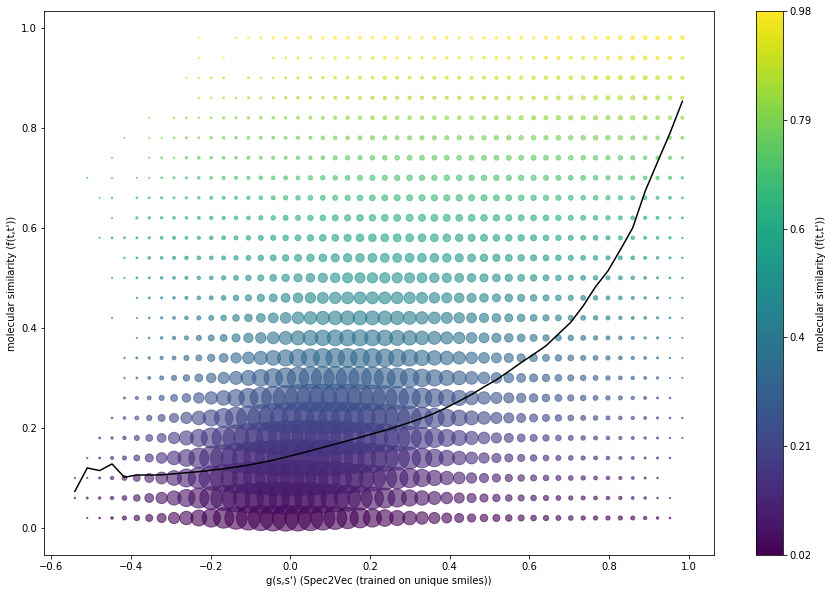

In [15]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on unique smiles)")

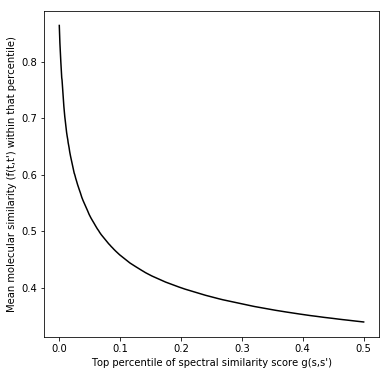

In [16]:
ref_score_w2v_cum_0 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

### 4.2. Model trained on all-GNPS (> 400,000 spectra)

+ Model was trained on all-GNPS dataset (about 500,000 spectra, 427100 of which were kept and used for training)

In [18]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


*** 
## 1) word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs

In [19]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = None, #'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.alculated centroid vectors for  100  of  9550  documents. documents. 300  of  9550  documents. 4090  of  9550  documents. 5560  of  9550  documents.  documents.9550  documents. Calculated centroid vectors for  8320  of  9550  documents. of  9550  documents. Calculated centroid vectors for  9000  of  9550  documents.

In [20]:
len(MS_measure.model_word2vec.wv.vocab)

144814

This has calculated (cosine) distances between all spectra in an all-vs-all fashion.
The "num_hits" closest candidates for each spectrum are listed in two matrices.

One stores the distances, the other the respective IDs.

### Calculate all-vs-all similarity matrix

In [21]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_1 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [26]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_1.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

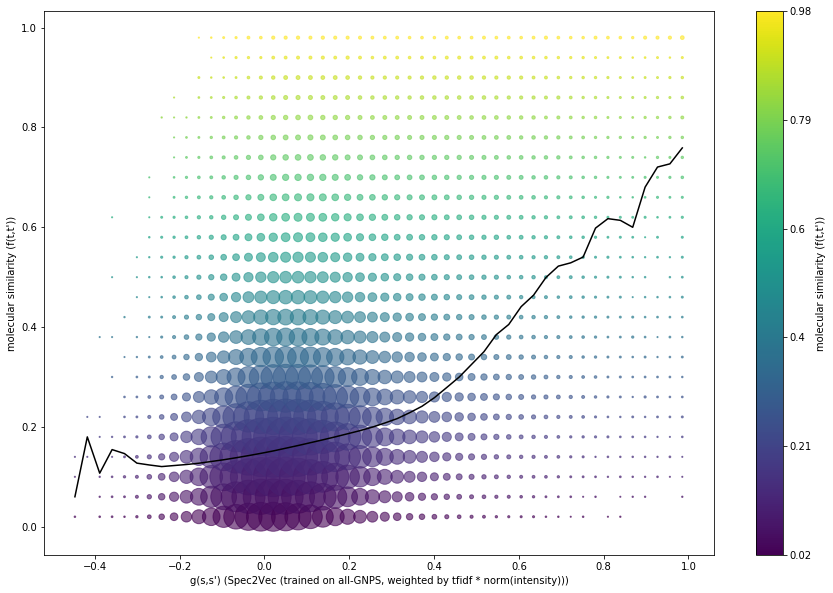

In [27]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on all-GNPS, weighted by tfidf * norm(intensity))")

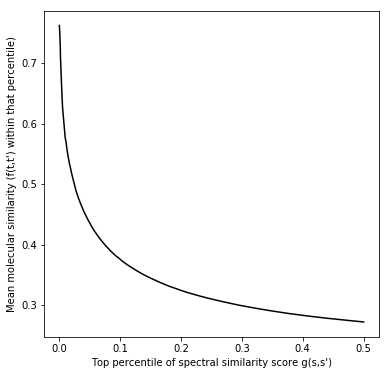

In [29]:
ref_score_w2v_cum_1 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 2) word vectors weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs

In [33]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.documents. 860  of  9550  documents.5600  of  9550  documents.5840  of  9550  documents. 6260  of  9550  documents.

In [34]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_2 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [36]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_2.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

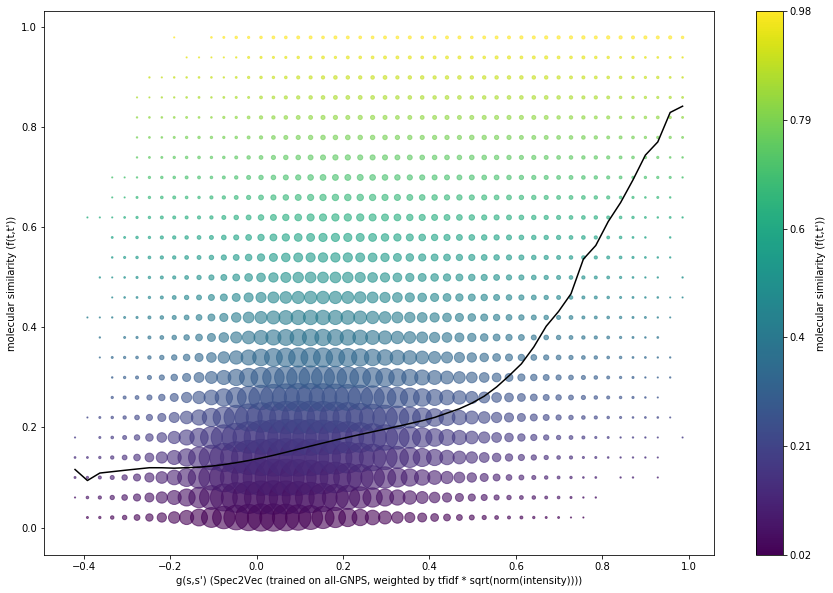

In [37]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on all-GNPS, weighted by tfidf * sqrt(norm(intensity)))")

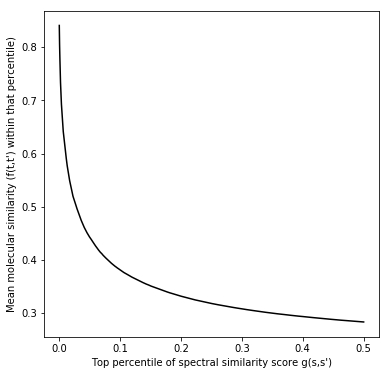

In [38]:
ref_score_w2v_cum_2 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 3) Ignore missing words + word vectors weighted by tfidf * norm(intensity)

In [40]:
MS_measure = SimilarityMeasures(MS_documents)
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


In [41]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [42]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = None, #'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents. documents. 6550  of  9550  documents. of  9550  documents.

In [43]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_3 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [44]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_3.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

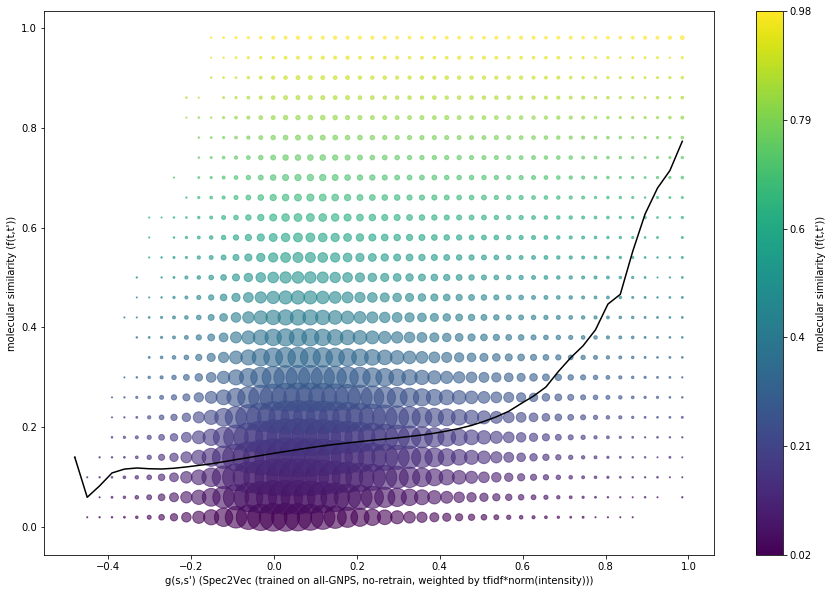

In [45]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on all-GNPS, no-retrain, weighted by tfidf*norm(intensity))")

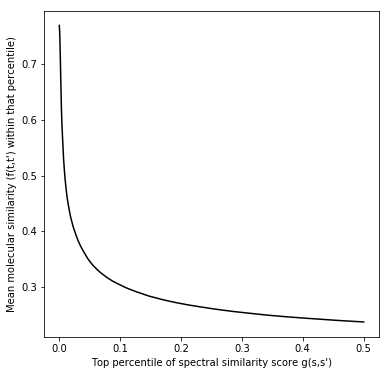

In [46]:
ref_score_w2v_cum_3 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 4) Ignore missing words + word vectors weighted by tfidf * sqrt(norm(intensity))

In [51]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents.1560  of  9550  documents. of  9550  documents.  of  9550  documents. of  9550  documents.

In [52]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_4 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [53]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr_4.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

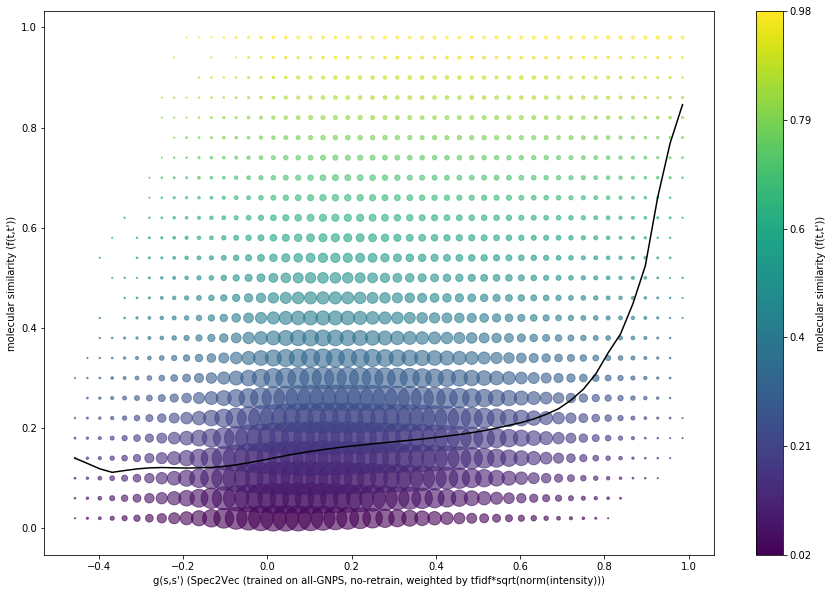

In [54]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on all-GNPS, no-retrain, weighted by tfidf*sqrt(norm(intensity))")

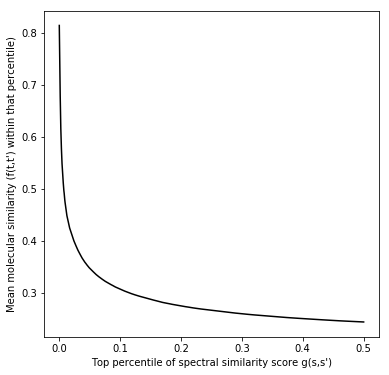

In [55]:
ref_score_w2v_cum_4 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

***
## 5) longer update training + word vectors weighted by tfidf * sqrt(norm(intensity))

In [57]:
MS_measure = SimilarityMeasures(MS_documents)
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


In [58]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [59]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 20)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  120  of  100 .No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.Calculated centroid vectors for  220  of  9550  documents. documents. of  9550  documents. 2350  of  9550  documents.  documents.  of  9550  documents.  of  9550  documents.  of  9550  documents. 6520  of  9550  documents. 7040  of  9550  documents.  of  9550  documents.  of  9550  documents.

In [ ]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr_5 = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [76]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

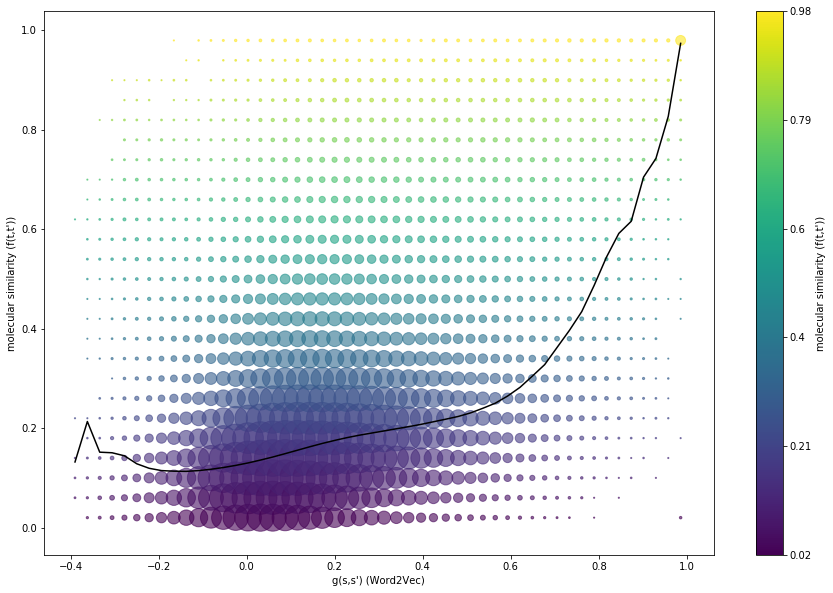

In [77]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.7767504248930106


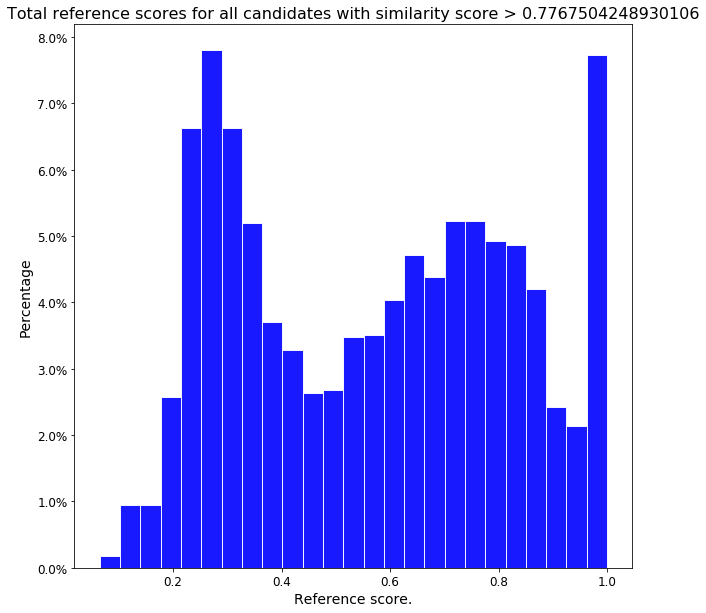

Percentage of highly similar molecules within selection:  56.82 %


In [78]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### 10) all-GNPS Word2Vec model (2 decimals) + word vectors weighted by tfidf * norm(intensity)**0.25

In [79]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [83]:
MS_documents_intensity2 = []
for doc in MS_documents_intensity:
    MS_documents_intensity2.append([x**0.5 for x in doc])  # add sqrt here --> together with next step = **0.25

In [84]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity2, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. 1630  of  9550  documents. 6820  of  9550  documents.  of  9550  documents. 8730  of  9550  documents.

In [85]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [86]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

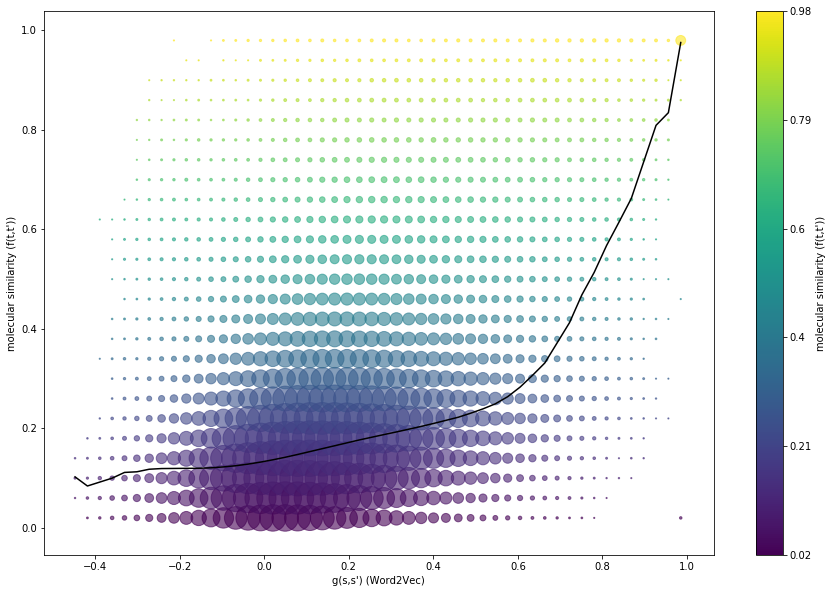

In [87]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.7609567492340849


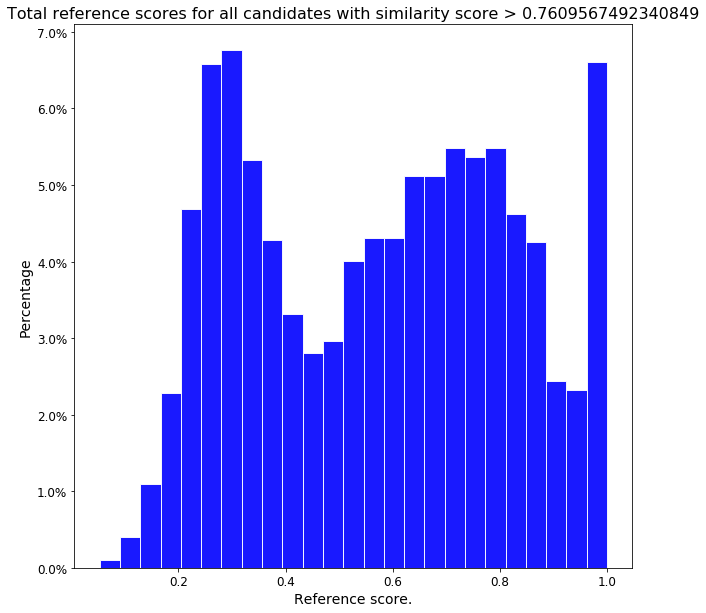

Percentage of highly similar molecules within selection:  59.41 %


In [88]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

# Compare to Word2Vec model trained on all-GNPS with 3 decimal resolution

In [54]:
# Import / Load data from gnps/unique smiles dataset
results_file = "filtered_data_unique_smiles_minpeak10_loss500_3dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 3,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\data\ filtered_data_unique_smiles_minpeak10_loss500_3dec.json
Data will be imported from  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\labeled_MS_data\GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf
Loaded 11134 molecules
RuntimeError for  77  peaks. Use mean intensity as threshold.
RuntimeError for  54  peaks. Use mean intensity as threshold.
Unclear TypeError for  100  peaks. Use mean intensity as threshold.
[] and y:  []
RuntimeError for  123  peaks. Use mean intensity as threshold.
RuntimeError for  92  peaks. Use mean intensity as threshold.


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\MS_functions.py:283: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\scipy\optimize\minpack.py:780: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq


Take  9550 spectra out of  11134 .
  Created documents for  1000  of  9550  spectra.No losses detected for:  1035 2836
No losses detected for:  1047 2857
No losses detected for:  1074 2916
  Created documents for  1200  of  9550  spectra.No losses detected for:  1237 3341
No losses detected for:  1277 3451
  Created documents for  1300  of  9550  spectra.No losses detected for:  1339 3601
No losses detected for:  1395 3717
  Created documents for  1500  of  9550  spectra.No losses detected for:  1570 4131
  Created documents for  1800  of  9550  spectra.No losses detected for:  1849 4649
  Created documents for  1900  of  9550  spectra.No losses detected for:  1936 4806
  Created documents for  2100  of  9550  spectra.No losses detected for:  2107 5113
No losses detected for:  2115 5130
No losses detected for:  2127 5151
No losses detected for:  2190 5270
  Created documents for  2200  of  9550  spectra.No losses detected for:  2218 5314
No losses detected for:  2219 5315
  Created doc

In [56]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

In [57]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  129170


### 7) Pre-trained Word2Vec model (3 decimals) + words vectors weighted by tfidf * norm(intensity)

In [58]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec3.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [59]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = None, #'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
3532  out of  129170  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.9550  documents. documents.9550  documents.  of  9550  documents. Calculated centroid vectors for  5530  of  9550  documents. Calculated centroid vectors for  6170  of  9550  documents. Calculated centroid vectors for  7490  of  9550  documents.8120  of  9550  documents. 9250  of  9550  documents.

In [60]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [61]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

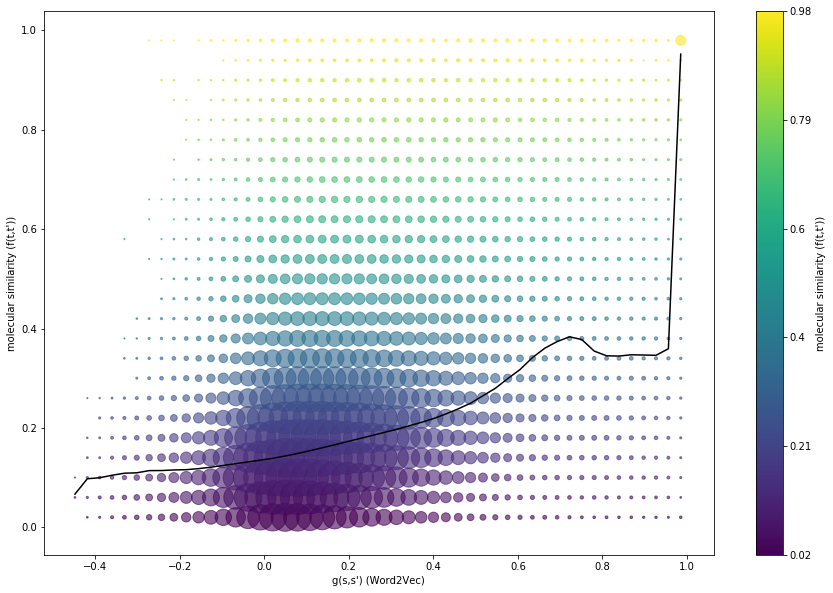

In [62]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.8397948430829402


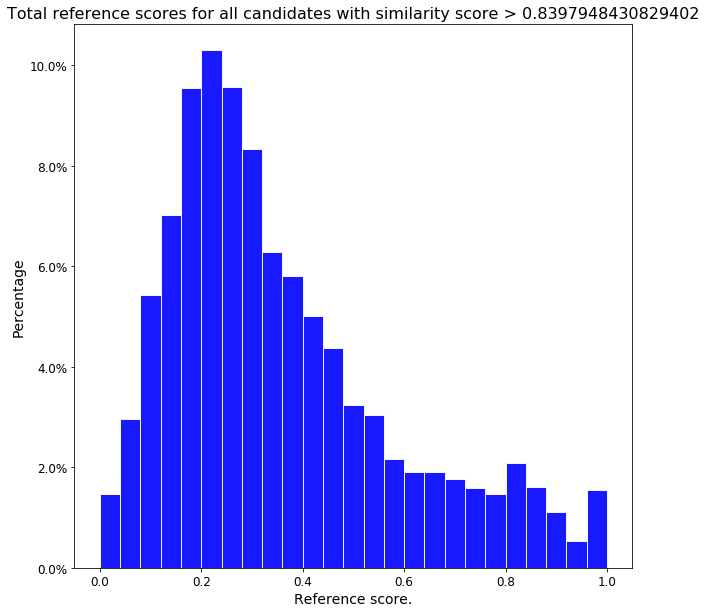

Percentage of highly similar molecules within selection:  23.94 %


In [63]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### 8) Pre-trained Word2Vec model (3 decimals) + words vectors weighted by tfidf * sqrt(norm(intensity))

In [64]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.9550  documents.3120  of  9550  documents.  of  9550  documents.5470  of  9550  documents.9550  documents.

In [65]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [66]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

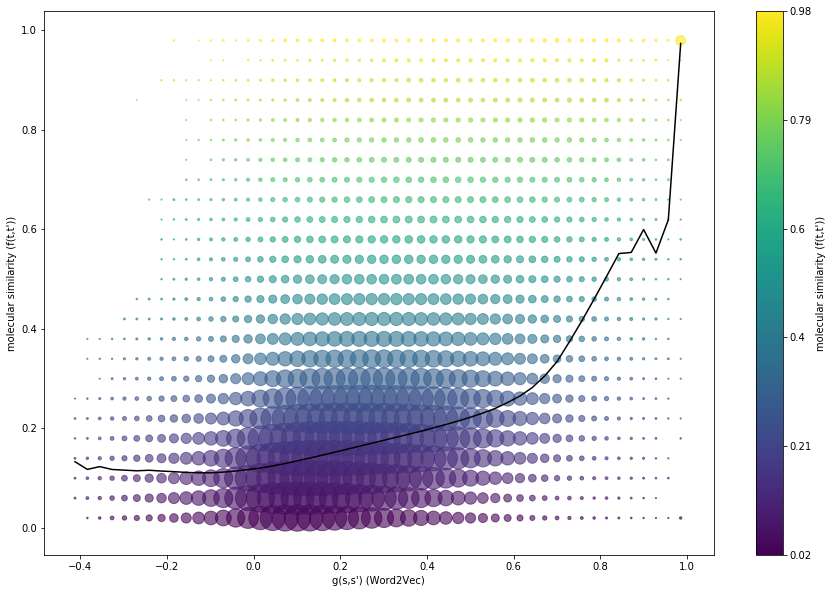

In [67]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.7986451588959455


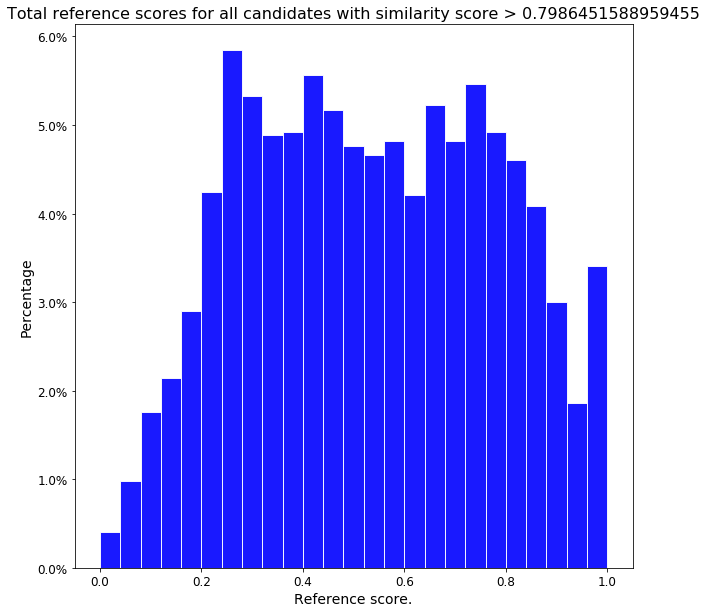

Percentage of highly similar molecules within selection:  55.86 %


In [68]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## Comparison plots

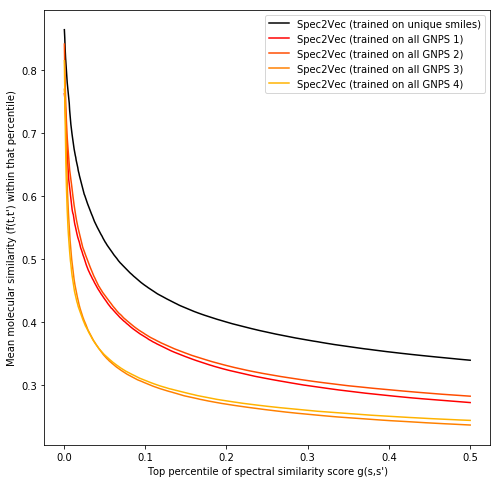

In [56]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

cmap1 = matplotlib.cm.get_cmap('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(8,8))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_0, color='black',
         label='Spec2Vec (trained on unique smiles)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_1, color=cmap1(0.0), #'purple',
         label='Spec2Vec (trained on all GNPS 1)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2, color=cmap1(0.3), #'crimson',
         label='Spec2Vec (trained on all GNPS 2)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_3, color=cmap1(0.5), #'pink',
         label='Spec2Vec (trained on all GNPS 3)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_4, color=cmap1(0.7), #'pink',
         label='Spec2Vec (trained on all GNPS 4)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Top_percentile_comparison_allGNPS.pdf')

### Old additional plots for all-gnps trained, word vectors weighted by tfidf * norm(intensity)

Set similarity threshold to:  0.6575499433892891


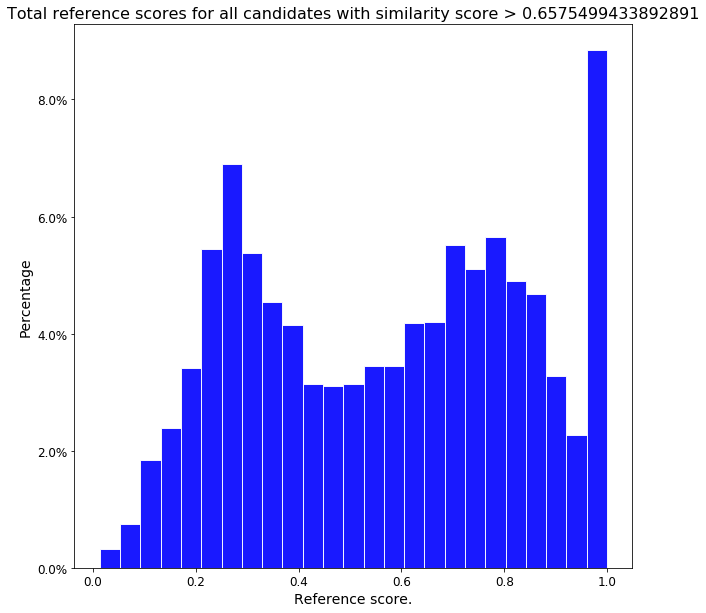

Percentage of highly similar molecules within selection:  58.64 %


In [16]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Old additional plots for all-gnps trained, word vectors weighted by tfidf * sqrt(norm(intensity))

Set similarity threshold to:  0.7399108269025307


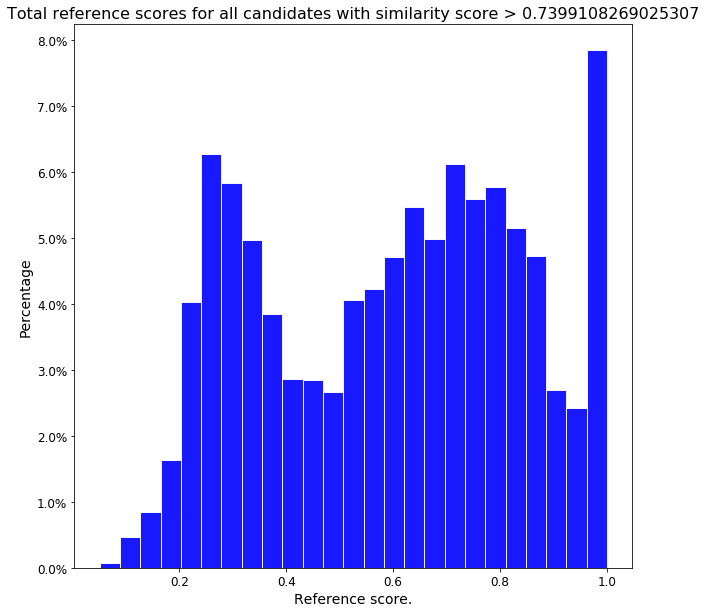

Percentage of highly similar molecules within selection:  63.71 %


In [24]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Old additional plots for all-gnps trained, word vectors weighted by tfidf * norm(intensity), no re-train

Set similarity threshold to:  0.7473745805961228


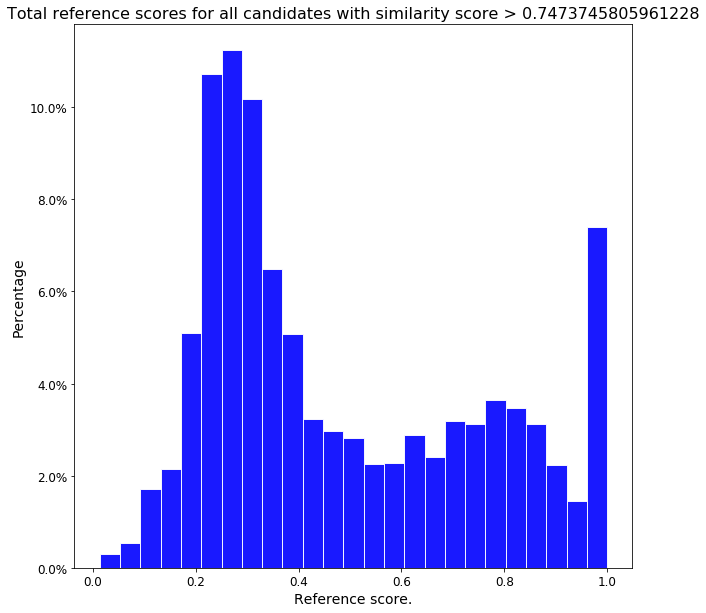

Percentage of highly similar molecules within selection:  40.29 %


In [32]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Old additional plots for all-gnps trained, word vectors weighted by tfidf * sqrt(norm(intensity)), no re-train

Set similarity threshold to:  0.8254387168904159


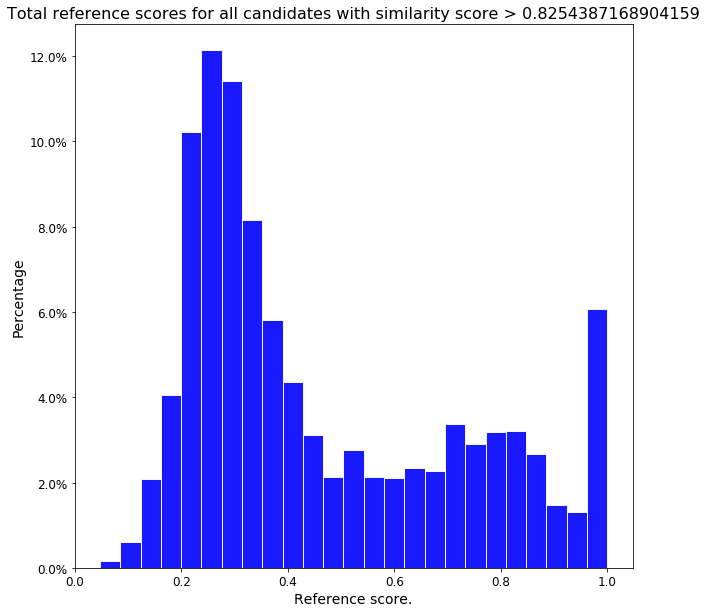

Percentage of highly similar molecules within selection:  35.74 %


In [43]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## Compare to Word2Vec model trained on the dataset itself!

In [44]:
#file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


### 5) word vectors weighted by tfidf + normalised intensity

In [45]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(extra_weights = MS_documents_intensity, 
                                tfidf_weighted=True, 
                                weight_method = None,
                                extra_epochs=5)
#MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.  of  9550  documents. Calculated centroid vectors for  2550  of  9550  documents.  documents. 9550  documents. Calculated centroid vectors for  8020  of  9550  documents. Calculated centroid vectors for  8260  of  9550  documents.

In [46]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [47]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

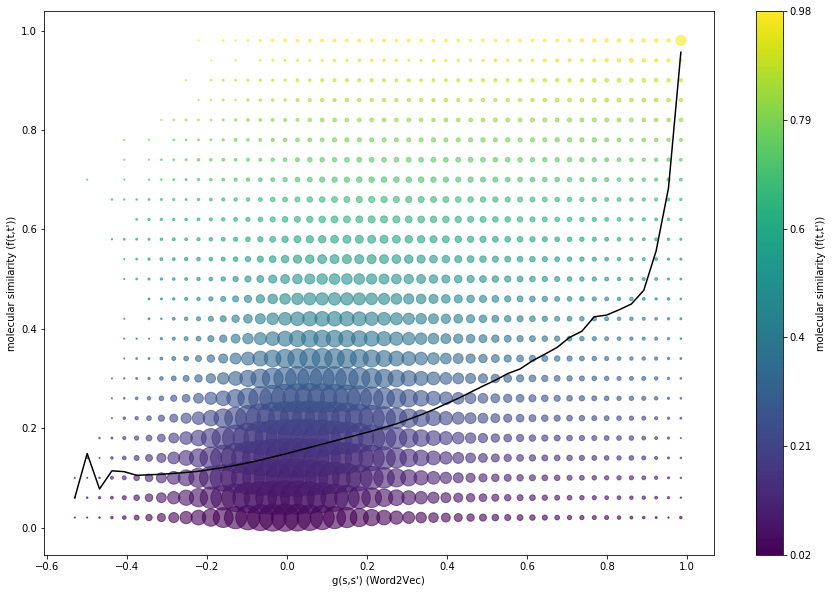

In [48]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.8699657331111491


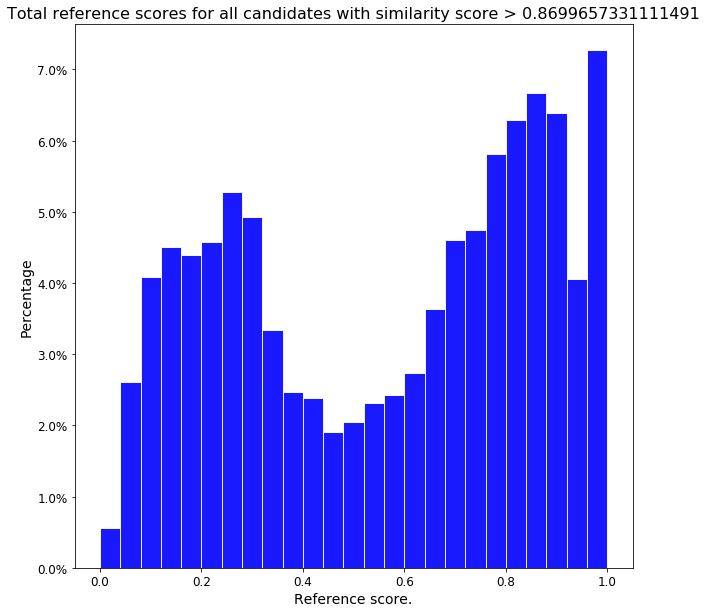

Percentage of highly similar molecules within selection:  58.97 %


In [25]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### 6) word vectors weighted by tfidf + sqrt(normalised intensity)

In [49]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(extra_weights = MS_documents_intensity, 
                                tfidf_weighted=True, 
                                weight_method = 'sqrt',
                                extra_epochs=5)
#MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.  of  9550  documents. Calculated centroid vectors for  3790  of  9550  documents.4320  of  9550  documents.5040  of  9550  documents. Calculated centroid vectors for  5140  of  9550  documents. Calculated centroid vectors for  7830  of  9550  documents.8240  of  9550  documents. documents.

In [50]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [51]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

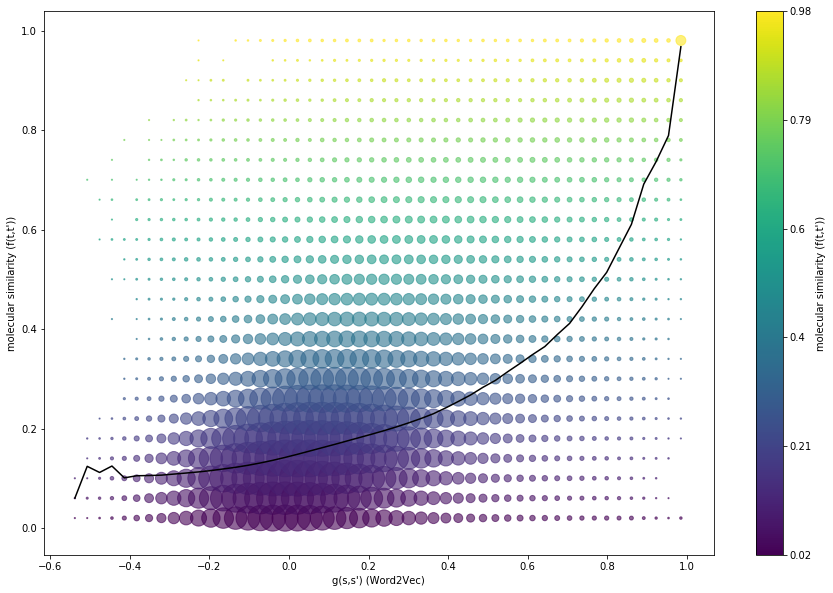

In [52]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.8505918971390208


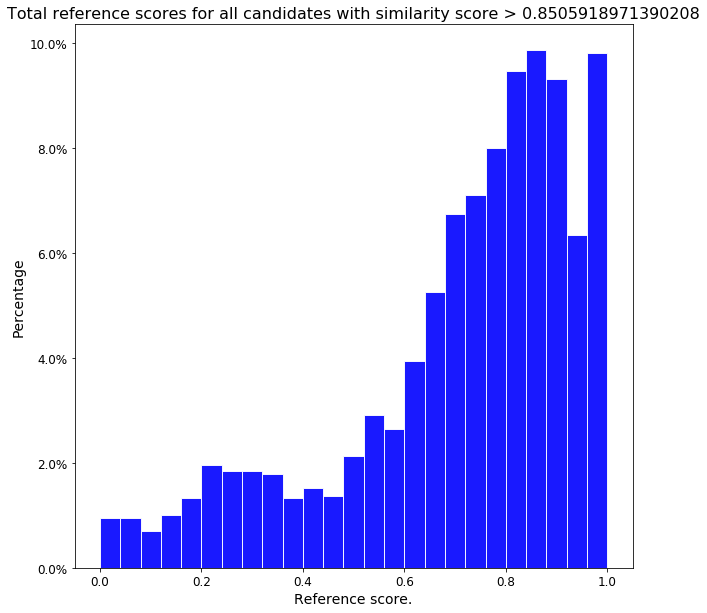

Percentage of highly similar molecules within selection:  83.4 %


In [33]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")